In [72]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt

In [74]:
file = open('database.txt')

lines = file.readlines()
url = lines[0].rstrip()
driver = lines[1].rstrip()
user = lines[2].rstrip()
password = lines[3].rstrip()

In [75]:
spark = SparkSession.builder.appName('CreditCardSystem').getOrCreate()

In [85]:
brnch_df = spark.read.format('jdbc').options(
    url=url,
    driver=driver,
    dbtable='CDW_SAPP_BRANCH',
    user=user,
    password=password).load()

crdt_df = spark.read.format('jdbc').options(
    url=url,
    driver=driver,
    dbtable='CDW_SAPP_CREDIT_CARD',
    user=user,
    password=password).load()

cstmr_df = spark.read.format('jdbc').options(
    url=url,
    driver=driver,
    dbtable='CDW_SAPP_CUSTOMER',
    user=user,
    password=password).load()

In [86]:
brnch_df = brnch_df.toPandas()
crdt_df = crdt_df.toPandas()
cstmr_df = cstmr_df.toPandas()

In [44]:
crdt_df

,BRANCH_CODE,CREDIT_CARD_NO,CUST_SSN,TRANSACTION_ID,TRANSACTION_TYPE,TRANSACTION_VALUE,TIMEID
0,156,4210653312478046,123455692,22562,Grocery,91.08,2018-08-13
1,114,4210653349028689,123459988,1,Education,78.90,2018-02-14
2,180,4210653342242023,123451310,45069,Bills,77.79,2018-03-15
3,114,4210653312478046,123455692,22563,Bills,22.20,2018-06-26
4,47,4210653312478046,123455692,22564,Grocery,77.54,2018-03-20
...,...,...,...,...,...,...,...
46689,131,4210653312478046,123455692,22557,Grocery,65.70,2018-06-02
46690,158,4210653312478046,123455692,22558,Bills,79.59,2018-02-16
46691,20,4210653312478046,123455692,22559,Healthcare,76.24,2018-06-15
46692,80,4210653312478046,123455692,22560,Education,81.56,2018-12-17


In [45]:
t_type = crdt_df.groupby('TRANSACTION_TYPE')['TRANSACTION_TYPE'].count()

In [46]:
t_type

TRANSACTION_TYPE
Bills            6861
Education        6638
Entertainment    6635
Gas              6605
Grocery          6549
Healthcare       6723
Test             6683
Name: TRANSACTION_TYPE, dtype: int64

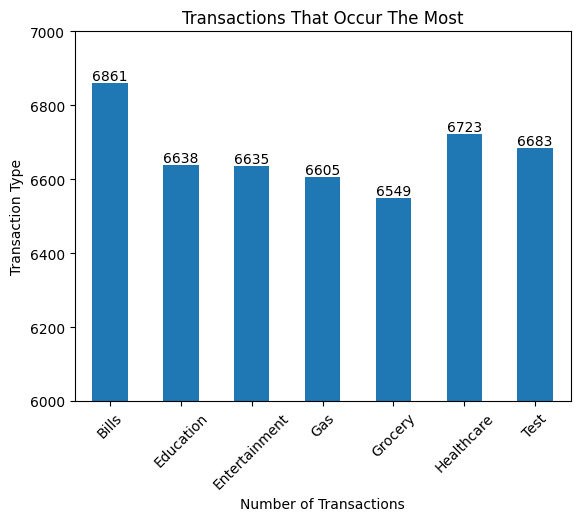

In [52]:
ax = t_type.plot.bar(rot=45)
ax.set_title('Transactions That Occur The Most')
ax.set_xlabel('Number of Transactions')
ax.set_ylabel('Transaction Type')
ax.set_ylim(6000, 7000)
ax.bar_label(ax.containers[0])

plt.savefig('Part3-1.png')

In [87]:
state = cstmr_df.groupby('CUST_STATE')['CUST_STATE'].count()

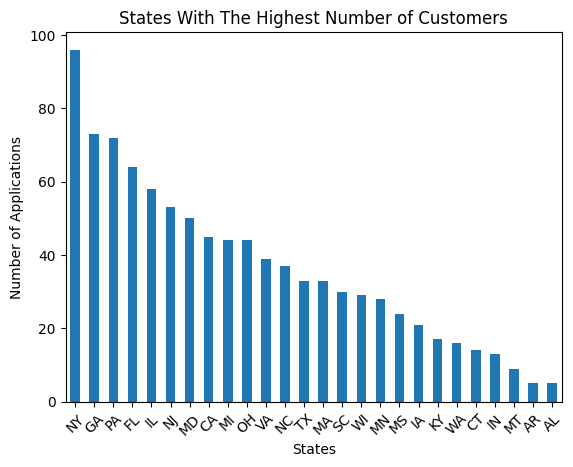

In [89]:
ax = state.sort_values(ascending=False).plot.bar(rot=45)

ax.set_title('States With The Highest Number of Customers')
ax.set_xlabel('States')
ax.set_ylabel('Number of Applications')

plt.savefig('Part3-2.png')

In [54]:
spenders = crdt_df.groupby('CUST_SSN')['TRANSACTION_VALUE'].sum()

In [55]:
spenders = spenders.sort_values(ascending=False).head(20)

In [56]:
spenders

CUST_SSN
123451125    5633.07
123452783    5548.14
123453486    5476.08
123458668    5314.97
123456678    5261.03
123452026    5241.18
123452518    5223.96
123454933    5203.08
123457547    5149.75
123452085    5133.29
123455898    5062.33
123456862    5046.07
123451701    5023.65
123457070    5014.01
123457654    5012.81
123452856    5008.23
123456079    5008.09
123456849    5006.73
123452890    4995.10
123456747    4986.13
Name: TRANSACTION_VALUE, dtype: float64

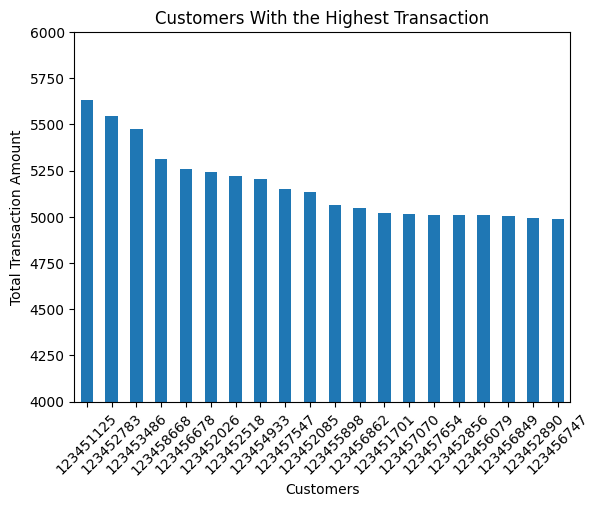

In [57]:
ax = spenders.plot.bar(rot=45)

ax.set_title('Customers With the Highest Transaction')
ax.set_xlabel('Customers')
ax.set_ylabel('Total Transaction Amount')
ax.set_ylim(4000, 6000)

plt.savefig('Part3-3.png')

In [58]:
top_month = crdt_df.groupby(crdt_df['TIMEID'].dt.month)[
    'TRANSACTION_VALUE'].sum()

In [59]:
top_month = top_month.sort_values(ascending=False).head(3)

In [60]:
top_month

TIMEID
10    202583.89
5     201310.26
12    201251.08
Name: TRANSACTION_VALUE, dtype: float64

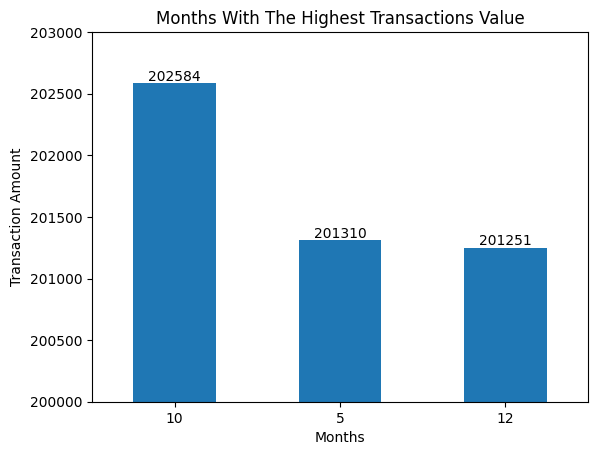

In [61]:
ax = top_month.plot.bar(rot='horizontal')

ax.set_title('Months With The Highest Transactions Value')
ax.set_xlabel('Months')
ax.set_ylabel('Transaction Amount')
ax.set_ylim(200000, 203000)
ax.bar_label(ax.containers[0])

plt.savefig('Part3-4.png')

In [62]:
healthcare = crdt_df[crdt_df['TRANSACTION_TYPE'] == 'Healthcare']

In [63]:
healthcare = crdt_df.groupby('BRANCH_CODE')['TRANSACTION_VALUE'].sum()

In [64]:
healthcare = healthcare.head(20)

In [65]:
healthcare

BRANCH_CODE
1     18157.57
2     21572.34
3     21749.91
4     20484.04
5     22053.74
7     22727.54
8     21809.74
9     22225.43
10    19763.47
11    19266.87
12    20430.59
14    20418.84
15    19516.27
16    22766.42
17    20912.11
18    22106.49
19    19622.87
20    19350.83
21    22356.68
22    20198.76
Name: TRANSACTION_VALUE, dtype: float64

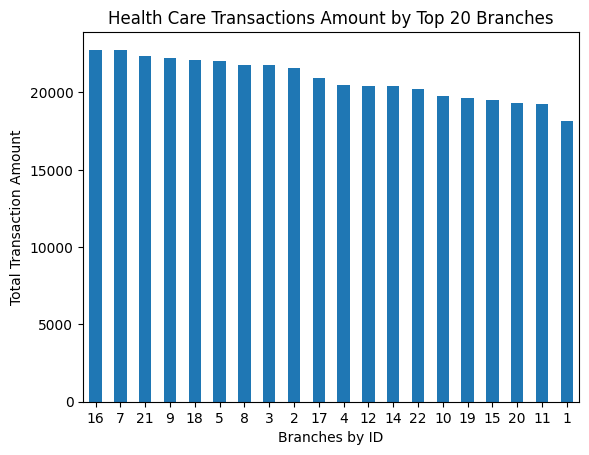

In [66]:
ax = healthcare.sort_values(ascending=False).plot.bar(rot='horizontal')

ax.set_title('Health Care Transactions Amount by Top 20 Branches')
ax.set_xlabel('Branches by ID')
ax.set_ylabel('Total Transaction Amount')

plt.savefig('Part3-5.png')